In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD as SVD
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

I'd like to be able to predict which terrorist group committed each terrorist act in this data set with 85% or higher accuracy while retaining as many of the classes (terrorist groups) in the model as possible.

In [2]:
#Reading the file
df1 = pd.read_excel('globalterrorismdb_0718dist.xlsx')

In [3]:
df1.shape

(181691, 135)

In [4]:
df1.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaT,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaT,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [5]:
#Exploring the columns
print(list(df1.columns))

['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended', 'resolution', 'country', 'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'location', 'summary', 'crit1', 'crit2', 'crit3', 'doubtterr', 'alternative', 'alternative_txt', 'multiple', 'success', 'suicide', 'attacktype1', 'attacktype1_txt', 'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt', 'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt', 'targtype2', 'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2', 'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt', 'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3', 'natlty3_txt', 'gname', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 'motive', 'guncertain1', 'guncertain2', 'guncertain3', 'individual', 'nperps', 'nperpcap', 'claimed', 'claimmode', 'claimmode_txt', 'claim2', 'claimmode2', 'claim

In [6]:
#Find columns with less than half nulls and keep these.
null_count = df1.isnull().sum()
null_count = pd.DataFrame(null_count[null_count<90000])
nullist = list(null_count.index)

In [7]:
df2 = df1[nullist]

In [8]:
#look at high-null columns still included in database
null_count2 = df2.isnull().sum()
null_count2 = pd.DataFrame(null_count2[null_count2>45000])
list(null_count2.index)

['summary',
 'nperps',
 'nperpcap',
 'claimed',
 'weapdetail',
 'nkillus',
 'nkillter',
 'nwoundus',
 'nwoundte',
 'scite1']

In [9]:
df2['nperps'].value_counts()

-99.0       82218
 1.0         8384
 2.0         6062
 3.0         2842
 4.0         2218
 5.0         1103
 6.0          784
 10.0         669
 20.0         658
 30.0         600
 50.0         546
 15.0         442
 100.0        439
 7.0          384
 8.0          365
 200.0        316
 40.0         288
 12.0         278
 25.0         183
 60.0         156
 9.0          144
 0.0          139
 300.0        136
 150.0        132
 70.0          88
 80.0          78
 24.0          75
 13.0          69
 11.0          58
 500.0         52
            ...  
 86.0           2
 41.0           2
 125.0          2
 900.0          1
 2500.0         1
 44.0           1
 52.0           1
 68.0           1
 190.0          1
 64.0           1
 3200.0         1
 25000.0        1
 84.0           1
 156.0          1
 38.0           1
 207.0          1
 42.0           1
 48.0           1
 204.0          1
 72.0           1
 53.0           1
 230.0          1
 138.0          1
 750.0          1
 49.0     

In [10]:
df2['nperps'].isnull().sum()
#Nperps has 82,000 -99 (unknown) values in addition to 71,000 null cells 
#I'll drop this column and I'll also drop dbsource since it's not pertinent to my analysis.

71115

In [11]:
#Drop columns that are not pertinent, are not updated properly, or are not covering all years.
df2=df2.drop(columns = ['dbsource','nperps','nperpcap','nkillus','nwoundus','nwoundte','nkillter','scite1','claimed'])

In [12]:
#Find non-numeric columns
cat = df2.select_dtypes(include=['object'])
for i in cat:
   column = cat[i]
   print(i)
   print(column.nunique())

country_txt
205
region_txt
12
provstate
2855
city
36674
summary
112492
attacktype1_txt
9
targtype1_txt
22
targsubtype1_txt
112
corp1
33238
target1
86006
natlty1_txt
215
gname
3537
weaptype1_txt
12
weapsubtype1_txt
30
weapdetail
19148


In [13]:
#Drop text columns for which there is already a corresponding numeric column or which are not pertinent.
df3 = df2.drop(columns = ['country_txt','summary','weapdetail','region_txt','attacktype1_txt','targtype1_txt','targsubtype1_txt','target1','corp1','natlty1_txt','weaptype1_txt','weapsubtype1_txt'])


In [14]:
#Drop a column that has less than 1000 non-zero values (and the code book says it was not used for all years.)
for i in df3:
   column = df3[i]
   if (df3[i] != 0).sum() < 1000:
        print (i)


individual


In [15]:
df4 = df3.drop(columns = ['individual'])

In [16]:
#Look at correlations between variables. If variables are highly correlated some can be dropped.
corrmat = df4.corr()

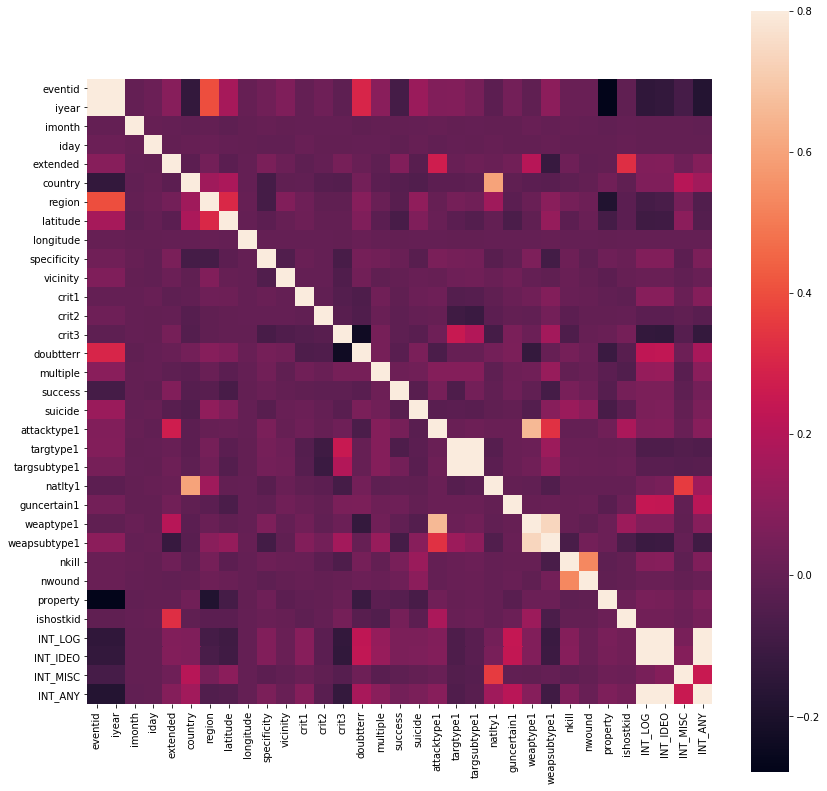

In [17]:
size = (14, 14)
fig, ax = plt.subplots(figsize=size)
sns.heatmap(corrmat, vmax=.8, square=True)

In [18]:
#I'll keep INT_ANY and drop the highly correlated INT_LOG and INT_IDEO which are included in INT_ANY.
#I'll remove weapsubtype1 and targsubtype1 since they are too highly correlated with type.
df5 = df4.drop(columns =['INT_LOG','INT_IDEO','targsubtype1','weapsubtype1'])

In [19]:
df5.shape

(181691, 32)

In [20]:
#Drop rows with nan.
df6 = df5.dropna()


In [21]:
df6.shape

(158134, 32)

In [22]:
#Drop rows where the terrorist group is unknown.
df7 = pd.DataFrame(df6[~df6['gname'].isin(['Unknown'])])

In [23]:
df7.shape

(82609, 32)

Plots of the attack counts for the terrorist organizations suggest that many will not have a enough datapoints for successful classification. I will have to put lower limits on the size of classes in this model.

In [24]:
df7['terrorgr_cat'] = df7['gname'].apply(lambda x: x[0:11]+'..' if len(x)>10 else x)

[Text(0,0.5,'Attack count'), Text(0.5,0,'Terrorist group')]

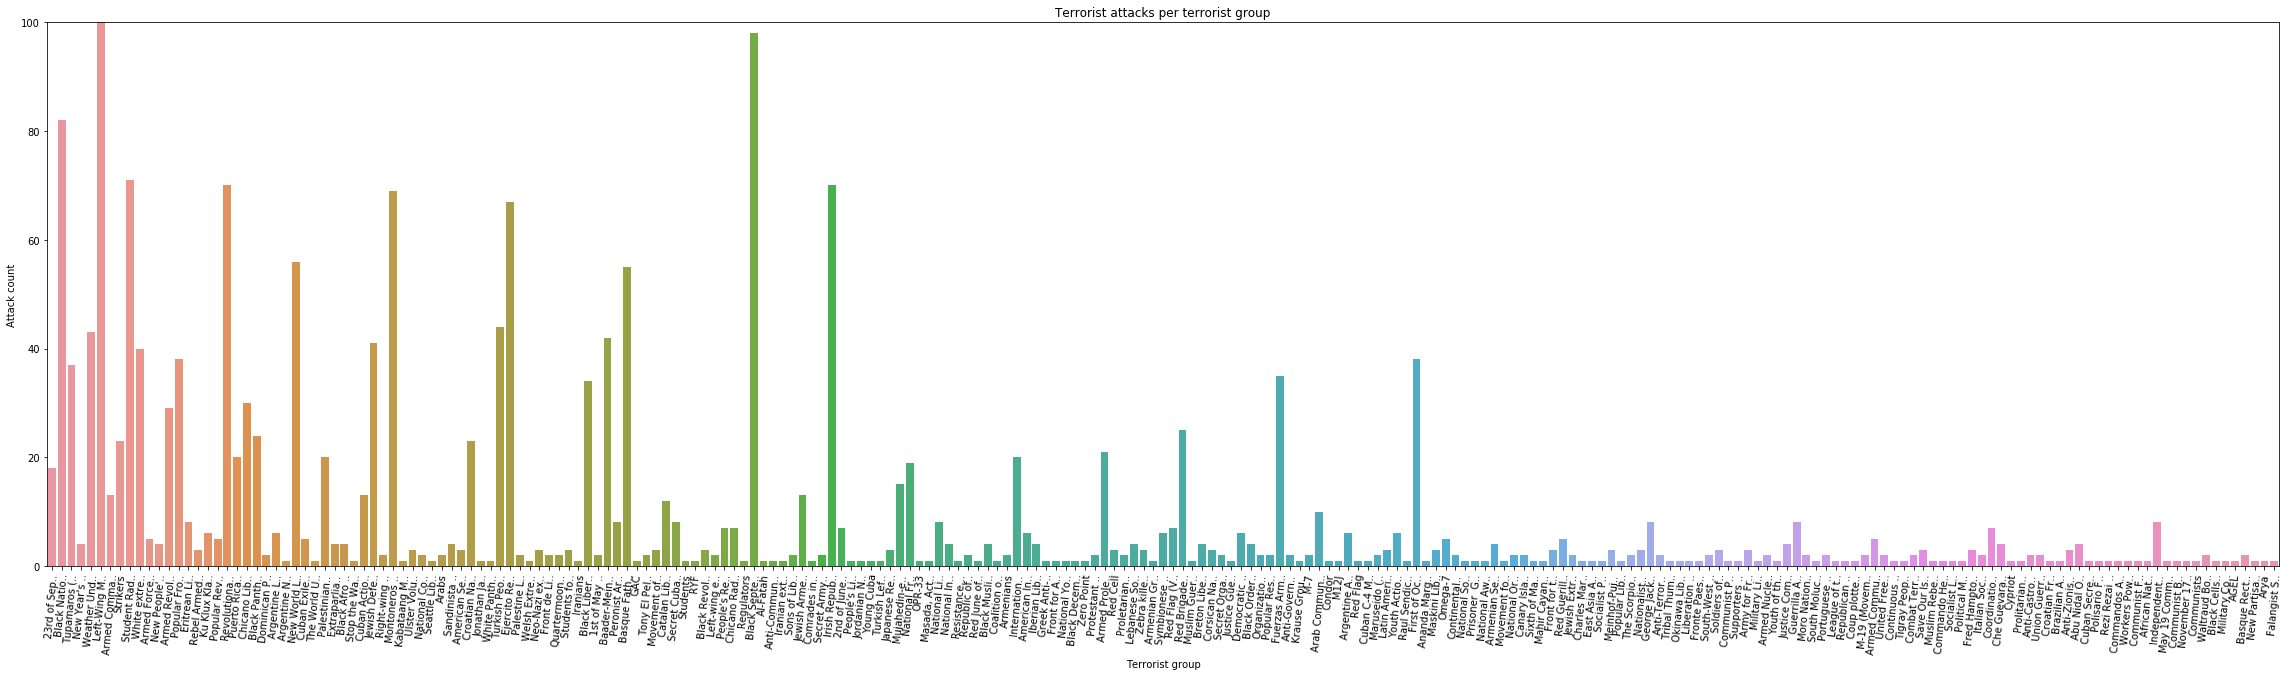

In [25]:
a4_dims = (40, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(df7.iloc[0:2000,:]['terrorgr_cat'])
plt.title('Terrorist attacks per terrorist group')
plt.xticks(rotation=85)
plt.ylim(0,100)
ax.set(xlabel = 'Terrorist group',ylabel = 'Attack count')

[Text(0,0.5,'Attack count'), Text(0.5,0,'Terrorist group')]

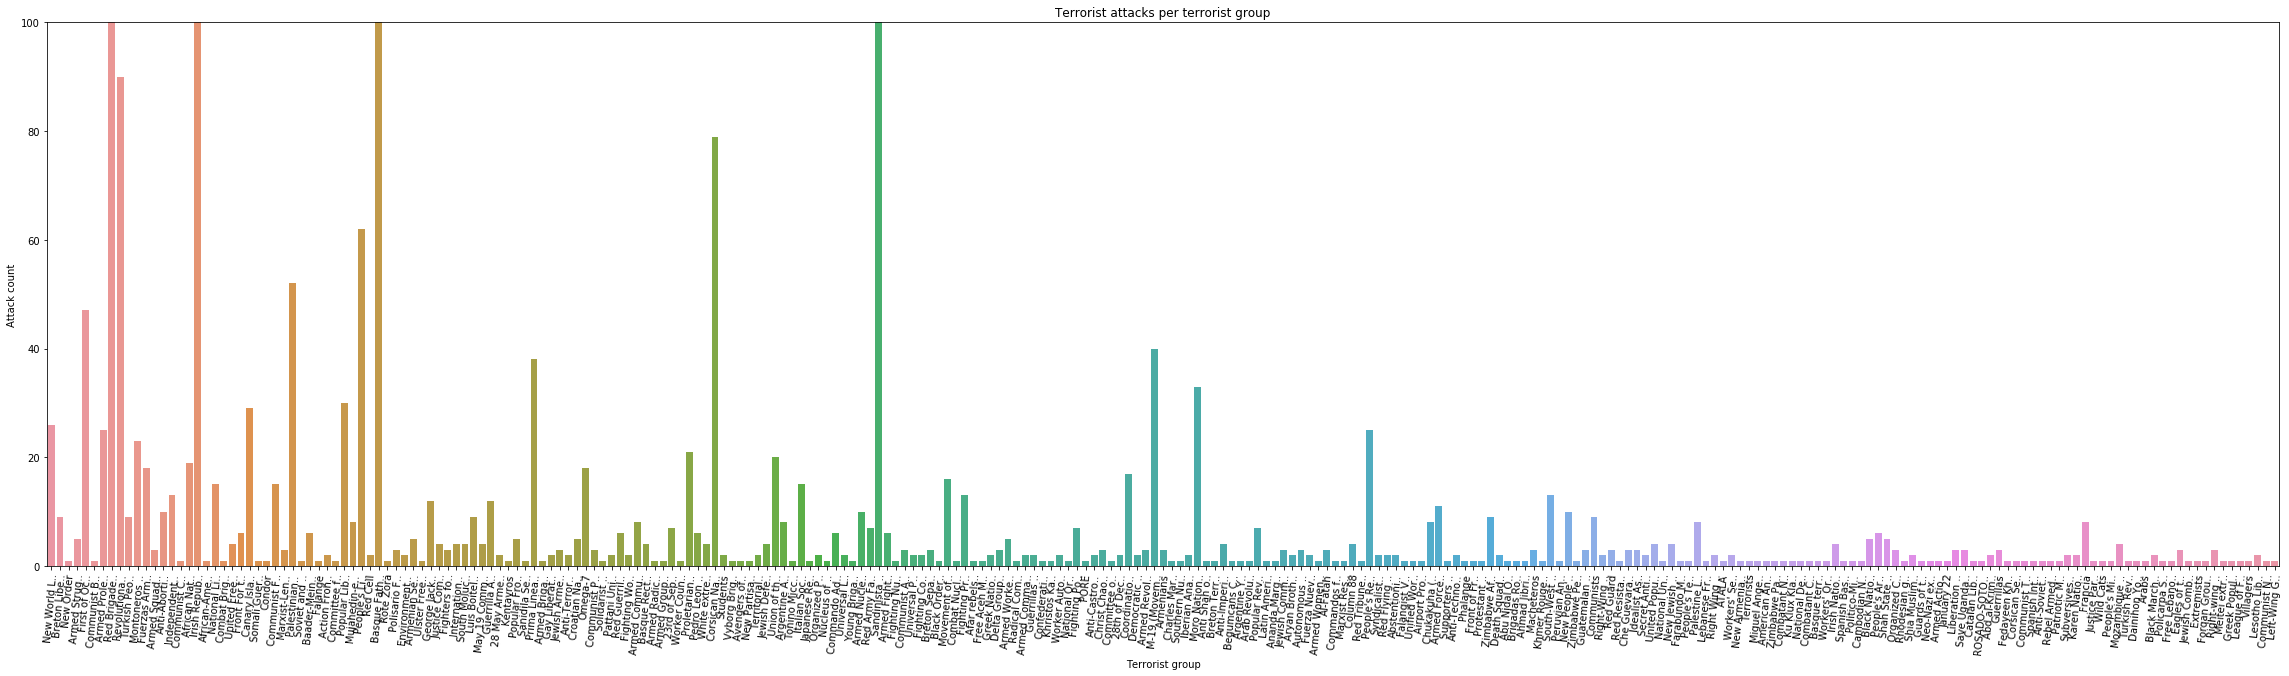

In [26]:
a4_dims = (40, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(df7.iloc[2000:4000,:]['terrorgr_cat'])
plt.title('Terrorist attacks per terrorist group')
plt.xticks(rotation=85)
plt.ylim(0,100)
ax.set(xlabel = 'Terrorist group',ylabel = 'Attack count')

In [27]:
#Drop eventID because it's not necessary for analysis.
df8 = df7.drop(columns = ['eventid'])

In [28]:
#Drop classes smaller than a certain size.
def drop_small_classes(df,series,size):
        gcounts = pd.DataFrame(df[series].value_counts().reset_index())
        gdrop = gcounts[gcounts[series]<size]
        gdroplist = list(gdrop['index'])
        keep = df[~df[series].isin(gdroplist)]
        return keep           

In [29]:
keep = drop_small_classes(df8,'gname',200)

In [30]:
#Look at terrorist groups included in final analysis
keep['gname'].value_counts()

Taliban                                                        6563
Islamic State of Iraq and the Levant (ISIL)                    4700
Shining Path (SL)                                              3770
New People's Army (NPA)                                        2391
Al-Shabaab                                                     2331
Farabundo Marti National Liberation Front (FMLN)               2245
Revolutionary Armed Forces of Colombia (FARC)                  2175
Kurdistan Workers' Party (PKK)                                 2129
Basque Fatherland and Freedom (ETA)                            1843
Communist Party of India - Maoist (CPI-Maoist)                 1820
Boko Haram                                                     1746
Irish Republican Army (IRA)                                    1673
Maoists                                                        1541
Liberation Tigers of Tamil Eelam (LTTE)                        1480
National Liberation Army of Colombia (ELN)      

In [31]:
#Gname is the class containing the terrorist groups I want to predict. I'll drop this column so I can separate it from the predictors for my model.
df9 = keep.drop(columns = ['gname'])

In [32]:
#Label gname column as y (target) for the model.
y = keep['gname']

In [33]:
#I'll need to get dummies so I can keep provstate and city in my analysis. Then I'll do SVD to cut down on the number of columns.
df10 = pd.get_dummies(df9)

In [34]:
df10.shape

(56535, 16185)

In [35]:
#Label X for SVD transformation.
X=df10

In [36]:
#I'll perform SVD on the predictors since it's good with sparse features and the data doesn't need standardizing.
svd = SVD(n_components=15)
svd.fit(X)  
print(svd.explained_variance_ratio_)  
print(svd.explained_variance_ratio_.sum())  


[1.07952219e-02 6.44270006e-01 1.74537924e-01 1.36273180e-01
 1.22861199e-02 1.12473453e-02 3.41858093e-03 3.30374853e-03
 1.82725053e-03 4.82180767e-04 3.78402635e-04 3.48915845e-04
 2.71860145e-04 2.24464305e-04 8.70029103e-05]
0.999752203811993


In [37]:
#I've explained over 99.9 percent of the variance with my SVD components. Now I'll transform the data.
finals = svd.transform(X)

In [38]:
#I plan to use classification as I'm labeling terrorist attacks. 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score


In [39]:
#First I'll creat training and test sets.
offset = int(finals.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = finals[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = finals[offset:], y[offset:]


In [40]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#Run random forest classifier and use cross valdiatin to check results.
rfc = ensemble.RandomForestClassifier(max_depth=5,n_jobs = -1)

In [41]:
y = y_train
X = X_train
cross_val_score(rfc,X,y,cv=3)

array([0.70921375, 0.70409923, 0.67818001])

This model doesn't have very high test accuracy (below). I wonder if Gradient Boosting Classifier will do better.

In [42]:
#Check accuracy of model with test data.
from sklearn.metrics import accuracy_score
rfc.fit(X_train,y_train)
predicted = rfc.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean test accuracy score: {accuracy:.3}')

Mean test accuracy score: 0.724


In [43]:
#I used subsampling, a max_depth of 2 and low n_estimators because 
#this gradient boosting classifier model tended to be overfit.
params = {'n_estimators':50,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params,subsample=.8)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)


In [44]:
#Check accuracy of model with train data in order to check for overfitting.
from sklearn.metrics import accuracy_score
accuracy_score(y_train, predict_train, normalize=True, sample_weight=None)

0.93006544618378

In [45]:
#Check accuracy of model with test data.
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict_test, normalize=True, sample_weight=None)

0.8656584416732998

The test accuracy for this model is above 85%. The accuracy with the training data is slightly higher which suggests  this model is slightly overfit. 

I can predict which of the terrorist organizations (with 200 attacks attributed to them) committed which attack, with an accuracy of about 87 percent. This Gradient Boosting Classifier is definitely a stronger model than the Random Forest Classifier. I'd like to see if I can keep the accuracy above 85% and run it with smaller classes included.

In [46]:
#Drop classes with fewer than 150 data points.
keep2 = drop_small_classes(df8,'gname', 150)

In [47]:
#Label y.
y2 = keep2['gname']

In [48]:
#Remove the y variable from the dataframe.
df20 = keep2.drop(columns = ['gname'])

In [49]:
#Get dummy columns so I can include provstate and city in my analysis.
df21 = pd.get_dummies(df20)

In [50]:
#I'll perform SVD on the predictors since it's good with sparse features and the data doesn't need standardizing.
svd = SVD(n_components=15)
svd.fit(df21)  
print(svd.explained_variance_ratio_)  
print(svd.explained_variance_ratio_.sum())  

[1.11510059e-02 6.39567654e-01 1.79010812e-01 1.35214145e-01
 1.27417761e-02 1.16048132e-02 3.38143644e-03 3.33082924e-03
 1.86737474e-03 4.93510438e-04 3.94581945e-04 3.56980706e-04
 3.04813255e-04 2.32491724e-04 9.26181092e-05]
0.9997448427679545


In [51]:
#Transform the data.
final2 = svd.transform(df21)

In [52]:
#Now I'll create training and test sets for the next Gradient Boosting Classifier.
offset2 = int(final2.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = final2[:offset2], y2[:offset2]

# And put 20% in the test set.
X_test, y_test = final2[offset2:], y2[offset2:]


In [53]:
#I used subsampling, a max_depth of 2 and low n_estimators because 
#this gradient boosting classifier model tended to be overfit.

params = {'n_estimators':50,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params,subsample=.8)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)


In [54]:
#Check training set accuracy.
from sklearn.metrics import accuracy_score
accuracy_score(y_train, predict_train, normalize=True, sample_weight=None)

0.8933990269646244

In [55]:
#Check test set accuracy.
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict_test, normalize=True, sample_weight=None)

0.8250185536406366

The accuracy of this model is not above 85% but it is still above 80% and it includes classes with only 150 data points.

Because only the terrorist organizations with 150+ terrorist attacks on record are included in these models, the accuracy of predictions for the attacks with attribution unknown cannot be determined.

Another option for getting the most out of this data is to split it into terrorist organizaion regions and try predicting terrorist groups responsible for terrorist attacks per terrorist organization region.